In [5]:
import pandas as pd
import numpy as np
import cv2
import os

In [7]:
filelist_df = pd.read_csv('EchoNet-Dynamic/FileList.csv')

# Cargar el archivo VolumeTracings.csv
volumetracings_df = pd.read_csv('EchoNet-Dynamic/VolumeTracings.csv')

In [69]:
videos = ['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', 
          '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi']
frames = [46, 3, 24, 91, 137, 132, 25, 49, 56, 45]

print(videos)
print(frames)

['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi']
[46, 3, 24, 91, 137, 132, 25, 49, 56, 45]


In [8]:
# Filtrar los primeros 300 elementos nones de la columna 'FileName'
videos = volumetracings_df['FileName'][volumetracings_df.index % 2 != 0].unique().tolist()

# Filtrar los primeros 300 elementos nones de la columna 'Frame'
frames = []
for video in videos[:600]:
    frame = volumetracings_df.loc[volumetracings_df['FileName'] == video, 'Frame'].values[0]
    frames.append(frame)

# Asegurarse de que ambas listas tengan 300 elementos
videos = videos[:300]
frames = frames[:300]

print(videos)
print(frames)

print(len(videos))
print(len(frames))

['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', '0X1059077339E

### Rectas

In [68]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                color=(0, 0, 0)
                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Después de recolectar todos los puntos, conectar cada punto con su vértice más cercano
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        # Determina el color en función de la posición de la iteración
        if j == 0:
            color = (0, 255, 0)  # Verde para la primera iteración
        elif 1 <= j <= 40:
            color = (0, 0, 255)  # Azul para las iteraciones del 2 al 11
        elif j == 42:
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)  # Rojo para las iteraciones restantes

        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        cv2.line(mask, (x1, y1), (x2, y2), color, 1)  # Conectar puntos con el color correspondiente

    # Guarda la máscara
    mask_filename = os.path.join("images", f"frame_{frames[i]}_lineMask.jpg")
    cv2.imwrite(mask_filename, mask)

    print(f"Máscara del frame {frames[i]} del video {videos[i]} guardada como {mask_filename}")


KeyError: 0

### Polígono

In [26]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos y frames
all_points = []

for i in range(len(videos)):
    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        ret, frame = cap.read()
        if ret:
            # Define la carpeta donde se guardarán las imágenes
            frame_path = "images/frames/"
            masks_folder = "images/masks/"
            
            # Verifica si la carpeta existe, si no, la crea
            if not os.path.exists(frame_path):
                os.makedirs(frame_path)
            if not os.path.exists(masks_folder):
                os.makedirs(masks_folder)

            # Guarda el primer frame como una imagen en la carpeta "images"
            frame_filename = os.path.join(frame_path, f"{videos[i]}_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)

            print(f"Frame {frame_count} del video {videos[i]} guardado como {frame_filename}")

            # Recolecta los puntos en lugar de crear la máscara inmediatamente
            mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]

            current_points = []  # Almacena los puntos actuales
            for index, row in mask_coords.iterrows():
                x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                current_points.extend([(x1, y1), (x2, y2)])

            all_points.append(current_points)  # Agrega los puntos actuales a la lista

            # Después de recolectar los puntos, crear una máscara para el frame actual
            # Crear una máscara en blanco y negro
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)  # Solo un canal, sin necesidad de 3 canales

            # Convertir los puntos en un formato adecuado para cv2.polylines
            polygon_points = np.array(current_points, dtype=np.int32).reshape((-1, 1, 2))

            # Dibujar el polígono en la máscara
            cv2.polylines(mask, [polygon_points], isClosed=True, color=255, thickness=3)  # Color en blanco (255)

            # Guardar la máscara en blanco y negro
            mask_filename = os.path.join(masks_folder, f"{videos[i]}_{frame_count}_binaryMask.jpg")
            cv2.imwrite(mask_filename, mask)

            print(f"Máscara del frame {frame_count} del video {videos[i]} guardada como {mask_filename}")

        # Libera la captura
        cap.release()


Frame 0 del video 0X100009310A3BD7FC.avi guardado como images/frames/0X100009310A3BD7FC.avi_0.jpg
Máscara del frame 0 del video 0X100009310A3BD7FC.avi guardada como images/masks/0X100009310A3BD7FC.avi_0_binaryMask.jpg
Frame 0 del video 0X1002E8FBACD08477.avi guardado como images/frames/0X1002E8FBACD08477.avi_0.jpg
Máscara del frame 0 del video 0X1002E8FBACD08477.avi guardada como images/masks/0X1002E8FBACD08477.avi_0_binaryMask.jpg
Frame 0 del video 0X1005D03EED19C65B.avi guardado como images/frames/0X1005D03EED19C65B.avi_0.jpg
Máscara del frame 0 del video 0X1005D03EED19C65B.avi guardada como images/masks/0X1005D03EED19C65B.avi_0_binaryMask.jpg
Frame 0 del video 0X10075961BC11C88E.avi guardado como images/frames/0X10075961BC11C88E.avi_0.jpg
Máscara del frame 0 del video 0X10075961BC11C88E.avi guardada como images/masks/0X10075961BC11C88E.avi_0_binaryMask.jpg
Frame 0 del video 0X10094BA0A028EAC3.avi guardado como images/frames/0X10094BA0A028EAC3.avi_0.jpg
Máscara del frame 0 del video 

### Poligonos divididos (EDV / ESV)

In [ ]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Inicializa los colores
blue_color = (0, 0, 255)  # Azul
red_color = (255, 0, 0)  # Rojo

# Después de recolectar todos los puntos, crear dos imágenes diferentes con dos máscaras distintas
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask_x1y1 = np.zeros_like(frame, dtype=np.uint8)
    mask_x2y2 = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        if j < 21 * 2:
            cv2.polylines(mask_x1y1, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=blue_color, thickness=3)
        else:
            cv2.polylines(mask_x2y2, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=red_color, thickness=3)

    # Guardar las máscaras en imágenes separadas
    mask_x1y1_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_EDV.jpg")
    mask_x2y2_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_ESV.jpg")

    cv2.imwrite(mask_x1y1_filename, mask_x1y1)
    cv2.imwrite(mask_x2y2_filename, mask_x2y2)

    print(f"Máscara x1y1 del frame {frames[i]} del video {videos[i]} guardada como {mask_x1y1_filename}")
    print(f"Máscara x2y2 del frame {frames[i]} del video {videos[i]} guardada como {mask_x2y2_filename}")


KeyError: 0

# Red Neuronal (CNN)

In [47]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from tensorflow.keras import layers, models


image_dir = 'images/frames'
mask_dir = 'images/masks'

# Obtener lista de nombres de archivos
image_files = os.listdir(image_dir)[:300]
mask_files = os.listdir(mask_dir)[:300]

# Función para cargar y preprocesar imágenes y máscaras
def load_and_preprocess_data(image_files, mask_files):
    images = []
    masks = []
    for image_file in image_files:
        # Obtener el nombre base del archivo
        base_name = os.path.splitext(image_file)[0]
        # Construir el nombre del archivo de máscara correspondiente
        mask_file = base_name + '_binaryMask.jpg'
        
        # Cargar imágenes y máscaras
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        
        # Asegurarse de que todas las imágenes sean del mismo tamaño
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))
        
        # Normalizar imágenes y máscaras
        image = image / 255.0
        mask = mask / 255.0
        
        # Agregar el canal de profundidad (shape=(128, 128, 1))
        image = tf.expand_dims(image, axis=-1)
        mask = tf.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    return images, masks

# Cargar y preprocesar los datos
images, masks = load_and_preprocess_data(image_files, mask_files)

# Dividir los datos en conjuntos de entrenamiento y prueba
split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
train_masks = masks[:split_index]
test_images = images[split_index:]
test_masks = masks[split_index:]

# Definir la arquitectura de la U-Net
# Define the U-Net model architecture
def unet_model(input_size=(128, 128, 1)):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Continue with more convolutional layers and downsampling


    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(conv2)
    up2 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=3)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    # Continue with more decoding convolutional layers

    # Dropout layer
    conv3 = layers.Dropout(0.2)(conv3)

    # Output Layer
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv3)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Crear el modelo
model = unet_model()

def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def dice_loss(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    return 1 - dice_coefficient(y_true, y_pred)

# Compilar el modelo
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

# Resumen del modelo
print(model.summary())

# Entrenar el modelo
model.fit(train_images, train_masks, validation_data=(test_images, test_masks), epochs=100, batch_size=32)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 128, 128, 64)         640       ['input_12[0][0]']            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_90[0][0]']           
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_91[0][0]']           
 ng2D)                                                                                     

In [51]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU


image_dir = 'images/frames'
mask_dir = 'images/masks'

# Obtener lista de nombres de archivos
image_files = os.listdir(image_dir)[:300]
mask_files = os.listdir(mask_dir)[:300]

# Función para cargar y preprocesar imágenes y máscaras
def load_and_preprocess_data(image_files, mask_files):
    images = []
    masks = []
    for image_file in image_files:
        # Obtener el nombre base del archivo
        base_name = os.path.splitext(image_file)[0]
        # Construir el nombre del archivo de máscara correspondiente
        mask_file = base_name + '_binaryMask.jpg'
        
        # Cargar imágenes y máscaras
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        
        # Asegurarse de que todas las imágenes sean del mismo tamaño
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))
        
        # Normalizar imágenes y máscaras
        image = image / 255.0
        mask = mask / 255.0
        
        # Agregar el canal de profundidad (shape=(128, 128, 1))
        image = tf.expand_dims(image, axis=-1)
        mask = tf.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    return images, masks

# Cargar y preprocesar los datos
images, masks = load_and_preprocess_data(image_files, mask_files)

# Dividir los datos en conjuntos de entrenamiento y prueba
split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
train_masks = masks[:split_index]
test_images = images[split_index:]
test_masks = masks[split_index:]

# Definir la arquitectura de la U-Net
# Define the U-Net model architecture
def unet_model(input_size=(128, 128, 1)):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Continue with more convolutional layers and downsampling

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(conv2)
    up2 = layers.Conv2D(64, 2, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=3)
    conv3 = layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(merge2)
    conv3 = layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(conv3)

    # Continue with more decoding convolutional layers

    # Output Layer
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv3)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Crear el modelo
model = unet_model()

def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def dice_loss(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    return 1 - dice_coefficient(y_true, y_pred)

# Compilar el modelo
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

# Resumen del modelo
print(model.summary())

# Entrenar el modelo
model.fit(train_images, train_masks, validation_data=(test_images, test_masks), epochs=100, batch_size=32)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 128, 128, 64)         640       ['input_12[0][0]']            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_90[0][0]']           
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_91[0][0]']           
 ng2D)                                                                                     

KeyboardInterrupt: 

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Crear un generador de datos con transformaciones
datagen = ImageDataGenerator(
    rotation_range=20,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Aplicar aumento de datos a tus imágenes y máscaras
augmented_images = []
augmented_masks = []

for i in range(len(train_images)):
    image = train_images[i]
    mask = train_masks[i]

    # Convertir tensores de TensorFlow a arrays de NumPy
    image = image.numpy()
    mask = mask.numpy()

    # Aplicar transformaciones
    for _ in range(10):  # Genera 10 versiones aumentadas de cada imagen
        augmented_image = datagen.random_transform(image)
        augmented_mask = datagen.random_transform(mask)

        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_mask)

# Convertir los arrays de NumPy de nuevo a tensores de TensorFlow
augmented_images = tf.convert_to_tensor(augmented_images, dtype=tf.float32)
augmented_masks = tf.convert_to_tensor(augmented_masks, dtype=tf.float32)

# Entrenar el modelo con los datos aumentados
model.fit(augmented_images, augmented_masks, validation_data=(test_images, test_masks), epochs=10, batch_size=32)


Epoch 1/10
75/75 [==============================] - 234s 3s/step - loss: 0.4879 - dice_coefficient: 0.5121 - val_loss: 0.4226 - val_dice_coefficient: 0.5787
Epoch 2/10
75/75 [==============================] - 227s 3s/step - loss: 0.4708 - dice_coefficient: 0.5292 - val_loss: 0.4421 - val_dice_coefficient: 0.5592
Epoch 3/10
75/75 [==============================] - 220s 3s/step - loss: 0.4640 - dice_coefficient: 0.5360 - val_loss: 0.4444 - val_dice_coefficient: 0.5570
Epoch 4/10
75/75 [==============================] - 219s 3s/step - loss: 0.4564 - dice_coefficient: 0.5436 - val_loss: 0.4839 - val_dice_coefficient: 0.5173
Epoch 5/10
75/75 [==============================] - 211s 3s/step - loss: 0.4530 - dice_coefficient: 0.5470 - val_loss: 0.4570 - val_dice_coefficient: 0.5443
Epoch 6/10
75/75 [==============================] - 207s 3s/step - loss: 0.4487 - dice_coefficient: 0.5513 - val_loss: 0.4213 - val_dice_coefficient: 0.5796
Epoch 7/10
75/75 [==============================] - 218s 3

In [68]:
def post_process_mask(predicted_mask, threshold=0.5):
    thresholded_mask = (predicted_mask > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(thresholded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        largest_mask = np.zeros_like(thresholded_mask)
        cv2.drawContours(largest_mask, [largest_contour], -1, 1, thickness=cv2.FILLED)
        return largest_mask
    else:
        return thresholded_mask

1/1 [==============================] - 0s 100ms/step


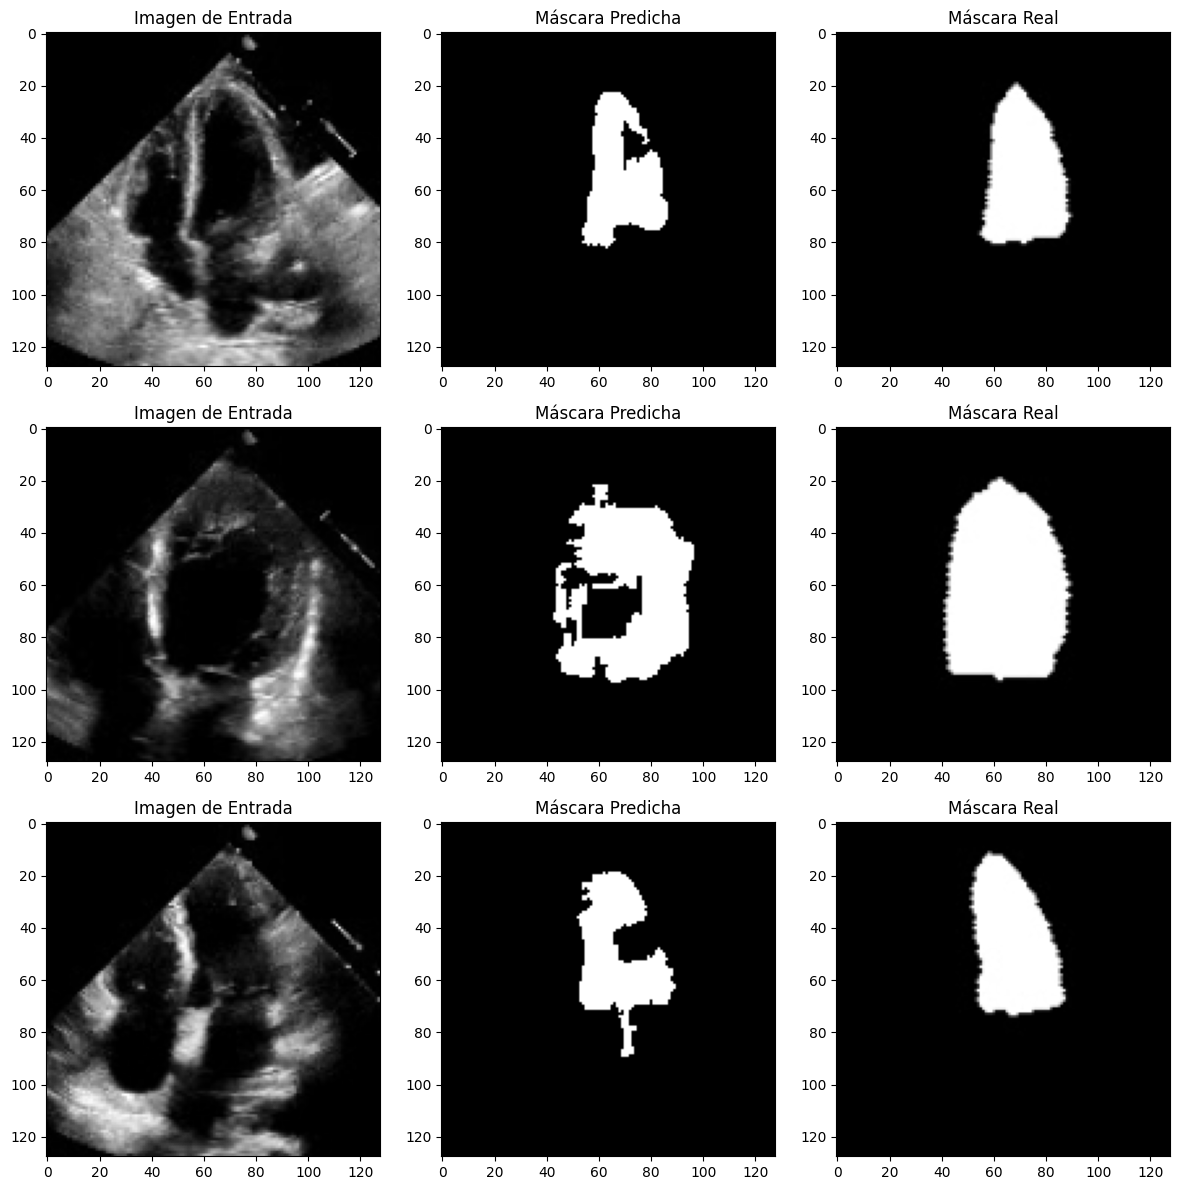

In [69]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

startFrame = 0

# Predecir máscaras para las primeras 3 imágenes de prueba
predicted_masks = model.predict(test_images[startFrame:startFrame + 3])

# Crear una figura con 3 columnas y 3 filas
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    # Primera columna: imagen de entrada
    axs[i, 0].imshow(test_images[i + startFrame], cmap='gray')
    axs[i, 0].set_title('Imagen de Entrada')
    
    # Segunda columna: máscara predicha (aplicando post-procesamiento)
    processed_mask = post_process_mask(predicted_masks[i])
    axs[i, 1].imshow(processed_mask, cmap='gray')
    axs[i, 1].set_title('Máscara Predicha')
    
    # Tercera columna: máscara real
    axs[i, 2].imshow(test_masks[i + startFrame], cmap='gray')
    axs[i, 2].set_title('Máscara Real')

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

# Red Omar


In [13]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from sklearn.model_selection import LeaveOneOut

# Definir la ruta a las imágenes y máscaras
image_dir = 'images/frames/'
mask_dir = 'images/masks/'

frames_folder = 'images/frames'
masks_folder = 'images/masks'

# Obtener lista de nombres de archivos
image_files = os.listdir(image_dir)[:300]
mask_files = os.listdir(mask_dir)[:300]

# Función para cargar y preprocesar imágenes y máscaras
def load_and_preprocess_data(image_files, mask_files):
    images = []
    masks = []
    for image_file in image_files:
        # Obtener el nombre base del archivo
        base_name = os.path.splitext(image_file)[0]
        # Construir el nombre del archivo de máscara correspondiente
        mask_file = base_name + '_binaryMask.jpg'
        
        # Cargar imágenes y máscaras
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        
        # Asegurarse de que todas las imágenes sean del mismo tamaño
        image = cv2.resize(image, (112, 112))
        mask = cv2.resize(mask, (112, 112))
        
        images.append(image)
        masks.append(mask)
    
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    
    # Normalizar imágenes y máscaras
    images /= 255.0
    masks = np.round(masks / 255.0)
    
    return images, masks

# Cargar y preprocesar los datos
images, masks = load_and_preprocess_data(image_files, mask_files)

# Inicializa el LeaveOneOut
loo = LeaveOneOut()

# Inicializa listas para almacenar conjuntos de entrenamiento y prueba
X_train = []
X_test = []
y_train = []
y_test = []

# Divide los datos en conjuntos de entrenamiento y prueba
for train_index, test_index in loo.split(masks):
    X_train.append(masks[train_index])
    X_test.append(masks[test_index])
    y_train.append(masks[train_index])
    y_test.append(masks[test_index])

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Definir la arquitectura de la red U-Net
def unet_model(input_size=(128, 128, 1)):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Continúa con más capas convolucionales y el proceso de downsampling

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(conv2)
    up2 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=3)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    # Continúa con más capas de convolución en la parte de decodificación

    # Capa de salida
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv3)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Crear una instancia del modelo U-Net
model = unet_model()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 64), (None, 64, 64, 64)]

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def dice_loss(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

In [ ]:
NUM_EPOCHS=10
BATCH_SIZE=32

# Convertir listas de imágenes y máscaras en matrices NumPy
X_train = np.array(X_train)
y_train = np.array(y_train)

# Asegurarse de que las dimensiones de los tensores sean adecuadas para el modelo
# Las dimensiones deben coincidir con las que has definido en la función unet_model
X_train = np.expand_dims(X_train, axis=-1)  # Agregar una dimensión de canal
y_train = np.expand_dims(y_train, axis=-1)

# Ahora, X_train y y_train son matrices NumPy que contienen todas las imágenes y máscaras de entrenamiento en un solo tensor

In [ ]:
# Verificar las dimensiones de tus imágenes
for image in X_train:
    print(image.shape)

for mask in y_train:
    print(mask.shape)

(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 112, 1)
(299, 112, 1

In [ ]:
y_train.size

1125196800

In [ ]:
import cv2
import numpy as np

desired_size = (128, 128)
X_train_resized = []

for images_batch in X_train:
    resized_images_batch = []  # Crear un lote para las imágenes redimensionadas
    for image in images_batch:
        # Redimensionar la imagen a la altura y ancho deseados
        resized_image = cv2.resize(image, dsize=(desired_size[1], desired_size[0]), interpolation=cv2.INTER_LINEAR)
        resized_images_batch.append(resized_image)
    X_train_resized.append(resized_images_batch)

# Convertir a un array NumPy
X_train_resized = np.array(X_train_resized)

# Asegurarte de que las dimensiones sean correctas (agregar una dimensión de canal)
X_train_resized = np.expand_dims(X_train_resized, axis=-1)

# Asegurarte de que todas las imágenes tengan las mismas dimensiones
X_train_resized = X_train_resized[:, 0, ...]  # Tomar la primera imagen de cada lote




In [ ]:
history = model.fit(X_train_resized, y_train, validation_data=(X_test, y_test), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
evaluation = model.evaluate(X_test, y_test)
print("Loss:", evaluation[0])
print("Dice Coefficient:", evaluation[1])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: -0.5443 - dice_coefficient: 1.5652

ValueError: in user code:

    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2025, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2013, in run_step  **
        outputs = model.test_step(data)
    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1893, in test_step
        y_pred = self(x, training=False)
    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 1 input(s), but it received 300 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 112, 112) dtype=float32>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 112, 112) dtype=float32>]
